In [ ]:
! gdown <id>

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_json('/content/games_metadata.json')

In [ ]:
df

,app_id,description,tags
0,10090,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,,[Action]
3,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...,...
48313,1803600,Gone Rogue is a tactical stealth game with RPG...,"[Stealth, Action, Real Time Tactics, Isometric..."
48314,1811990,"Take on the elements in Wildfrost, a tactical ...","[Card Battler, Difficult, Roguelike Deckbuilde..."
48315,1868120,Competitive multiplayer match with vehicles an...,"[FPS, Third-Person Shooter, Multiplayer, Shoot..."
48316,2206390,Feel the Neon in Your Bones! How would you lik...,"[3D Platformer, Rhythm, Parkour, 3D, Atmospher..."


In [ ]:
len(df)

48318

In [ ]:
df.dtypes

app_id          int64
description    object
tags           object
dtype: object

In [ ]:
df = df[df['description'] != ''].copy()

In [ ]:
len(df)

39346

Создаем целевую переменную - попробуем предсказать тег action

In [ ]:
def action_in_tag_list(row):
    return 'Action' in list(row['tags'])

In [ ]:
df['action'] = df.apply(action_in_tag_list,axis=1)

In [ ]:
df['action'].value_counts()

False    22060
True     17286
Name: action, dtype: int64

Разделяем train, val, test

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,train_size=0.6,random_state=42,stratify=df['action'])
val, test = train_test_split(test,train_size=0.5,random_state=42,stratify=test['action'])

In [ ]:
train_full = pd.concat([train,val])

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

Катбуст умеет извлекать фичи из текста
https://github.com/catboost/catboost/blob/master/catboost/tutorials/events/2020_06_04_catboost_tutorial/text_features.ipynb

In [ ]:
text_features = ['description']
X = ['description']
y = ['action']

Создаем пулы

In [ ]:
from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  text_features=text_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  text_features=text_features
                 )

test_data = Pool(data=test[X],
                  label=test[y],
                  text_features=text_features
                 )

train_full_data = Pool(data=train_full[X],
                       label=train_full[y],
                       text_features=text_features
                       )

Параметры модели

In [ ]:
params = {'verbose':100,
          'eval_metric':'F1',
          'loss_function': 'Logloss',
          'random_seed':42,
          'learning_rate':0.01}

In [ ]:
#from catboost import cv

In [ ]:
#cv_data = cv(
#    params = params,
#    pool = train_full_data,
#   fold_count=5,
#    shuffle=True,
#    partition_random_seed=0,
#    stratified=False,
#    verbose=False
#)

Модель

In [ ]:
model = CatBoostClassifier(**params)

Обучение

In [ ]:
model.fit(train_data,eval_set=valid_data)

0:	learn: 0.6813187	test: 0.7065403	best: 0.7065403 (0)	total: 246ms	remaining: 4m 5s
100:	learn: 0.6856258	test: 0.7109241	best: 0.7187879 (5)	total: 20.5s	remaining: 3m 2s
200:	learn: 0.6882767	test: 0.7128775	best: 0.7187879 (5)	total: 40.8s	remaining: 2m 42s
300:	learn: 0.6888692	test: 0.7147799	best: 0.7187879 (5)	total: 1m 3s	remaining: 2m 26s
400:	learn: 0.6903992	test: 0.7145558	best: 0.7187879 (5)	total: 1m 21s	remaining: 2m 2s
500:	learn: 0.6928329	test: 0.7161737	best: 0.7187879 (5)	total: 1m 41s	remaining: 1m 40s
600:	learn: 0.6953849	test: 0.7180776	best: 0.7187879 (5)	total: 2m 1s	remaining: 1m 20s
700:	learn: 0.6963133	test: 0.7185930	best: 0.7191329 (666)	total: 2m 19s	remaining: 59.6s
800:	learn: 0.6975922	test: 0.7197112	best: 0.7197112 (795)	total: 2m 39s	remaining: 39.5s
900:	learn: 0.6994388	test: 0.7204267	best: 0.7206275 (898)	total: 2m 57s	remaining: 19.5s
999:	learn: 0.7019386	test: 0.7214196	best: 0.7215071 (988)	total: 3m 17s	remaining: 0us

bestTest = 0.7215

На лучшей итерации обучаем модель на train+val

In [ ]:
params = {'iterations': 989,
          'verbose':100,
          'eval_metric':'F1',
          'loss_function': 'Logloss',
          'random_seed':42,
          'learning_rate':0.01}

In [ ]:
model.fit(train_full_data)

0:	learn: 0.6913391	total: 382ms	remaining: 6m 21s
100:	learn: 0.6966318	total: 21.7s	remaining: 3m 13s
200:	learn: 0.6986957	total: 45.6s	remaining: 3m 1s
300:	learn: 0.7007040	total: 1m 6s	remaining: 2m 34s
400:	learn: 0.7018929	total: 1m 26s	remaining: 2m 9s
500:	learn: 0.7043748	total: 1m 47s	remaining: 1m 46s
600:	learn: 0.7057229	total: 2m 6s	remaining: 1m 24s
700:	learn: 0.7069026	total: 2m 27s	remaining: 1m 2s
800:	learn: 0.7078913	total: 2m 47s	remaining: 41.7s
900:	learn: 0.7088490	total: 3m 7s	remaining: 20.6s
999:	learn: 0.7102363	total: 3m 27s	remaining: 0us


Оченим качество на train+val

In [ ]:
train_full['pred_action'] = model.predict_proba(train_full[X])[:,1]

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

In [ ]:
fprs, tprs, thrs = roc_curve(train_full['action'],train_full['pred_action'])

In [ ]:
roc = pd.DataFrame({'fpr':fprs,'tpr':tprs,'thr':thrs})

Roc Auc curve

<Axes: xlabel='fpr'>

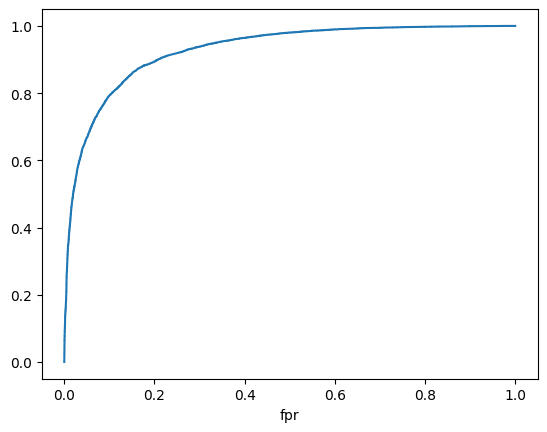

In [ ]:
roc.set_index('fpr')['tpr'].plot()

Оценим на test

In [ ]:
test['pred_action'] = model.predict_proba(test[X])[:,1]

In [ ]:
fprs, tprs, thrs = roc_curve(test['action'],test['pred_action'])

In [ ]:
roc = pd.DataFrame({'fpr':fprs,'tpr':tprs,'thr':thrs})

Roc Auc curve

<Axes: xlabel='fpr'>

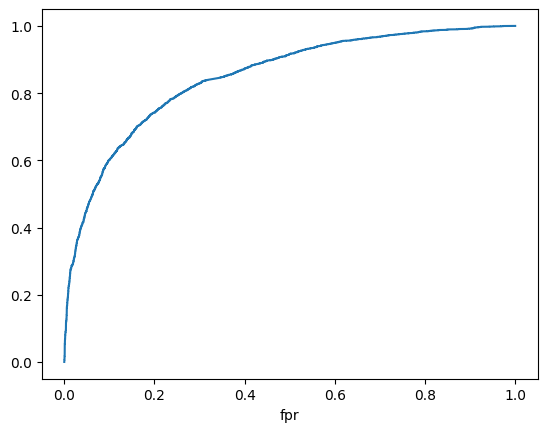

In [ ]:
roc.set_index('fpr')['tpr'].plot()

Выберем оптимальный порог

In [ ]:
thrs = [0] + list(test['pred_action'].unique())

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
result = []
for thr in tqdm(thrs):
	test['pred_action_val'] = (test['pred_action'] > thr) * 1
	result.append((thr,
		             f1_score(test['action'],test['pred_action_val'])))

  0%|          | 0/7704 [00:00<?, ?it/s]

In [ ]:
t = pd.DataFrame(result,columns=['thr','f1'])

In [ ]:
t[t['f1'] == t['f1'].max()]

,thr,f1
1377,0.338837,0.751594


In [ ]:
test['pred_action_res'] = (test['pred_action'] > 0.338837) * 1

In [ ]:
from sklearn.metrics import classification_report

Итоговые метрики на test

In [ ]:
print(classification_report(test['action'],test['pred_action_res']))

              precision    recall  f1-score   support

       False       0.83      0.72      0.77      4412
        True       0.70      0.82      0.75      3458

    accuracy                           0.76      7870
   macro avg       0.76      0.77      0.76      7870
weighted avg       0.77      0.76      0.76      7870

